In [1]:
from cifar_utils import *
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.datasets import cifar10

In [2]:
x_train, train_labels, x_test, test_labels = load_CIFAR10_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

y_train = keras.utils.to_categorical(train_labels, 10) 
y_test = keras.utils.to_categorical(test_labels, 10) 

del train_labels, test_labels


170500096/170498071 [==============================] - 11s 0us/step


In [4]:
model = load_model('best_model.h5')

# **PGD Attack :**
We want to hijack sample x :

$x_0 = x$ \\
$ x_{t+1} = \Pi_{B_{l^{\infty}}(x,\delta)} [x_t + \alpha sgn(∇_xL(θ, x_t, y))]$


In [13]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)

        loss = loss_object(prediction, label)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    return signed_grad


In [14]:
def attack_PGD(x, y, delta, step_size, max_iter=100, verbose = 0):
    pert_x = x
    cpt = 0
    while True :
        cpt += 1
        pert = adversarial_pattern(pert_x, y)
        new_pert_x = pert_x + step_size*pert
        #First clip serves to keep values between 0 and 1 and second clip for attacked examples to stay within the original examples l_inf sphere
        new_pert_x = np.clip(np.clip(new_pert_x, x-delta, x+delta),0,1)

        if cpt == max_iter :
            pert_x = new_pert_x 
            if verbose :
              print("max iter break")
            break
        
        pert_x = new_pert_x
    
    return pert_x

In [15]:
## A generator to generate PGD adversarial attacks from train
def generate_adversarials_train_PGD(batch_size,delta, step_size, max_iter , seed=None, verbose = 0):
    random.seed(seed)
    x = []
    y = []
    indices_chosen = []

    if batch_size == None :
      indices_chosen = list(range(len(x_train)))
    else :
      for batch in range(batch_size):
          indices_chosen.append(random.randint(0, x_train.shape[0]-1))

    labels = y_train[indices_chosen]
    ori_images = x_train[indices_chosen]

    adversarial = attack_PGD(ori_images,labels, delta, step_size, max_iter, verbose)

    
    return indices_chosen, adversarial, labels
## A generator to generate PGD adversarial attacks from test set

def generate_adversarials_test_PGD(batch_size,delta, step_size, max_iter , seed=None, verbose = 0):
    random.seed(seed)
    x = []
    y = []
    indices_chosen = []

    if batch_size == None :
      indices_chosen = list(range(len(x_test)))
    else :
      for batch in range(batch_size):
          indices_chosen.append(random.randint(0, x_test.shape[0]-1))

    labels = y_test[indices_chosen]
    ori_images = x_test[indices_chosen]

    adversarial = attack_PGD(ori_images,labels, delta, step_size, max_iter, verbose)

    
    return indices_chosen, adversarial, labels

# Hyper-parameters tuning :

In [76]:
batch_size = 5000
max_iter = 20

acc_orig_imgs = None
acc_advers_imgs = []   

#fix experiments randomness
seed = 0 

start = 0

print(f'Accuracy on the same batch of adversarial images for :')
for alpha in np.arange(0.01,0.06,0.005):
  for delta in np.arange(0.05,0.1,0.005):

      indices_chosen, x_adversarial_train, y_adversarial_train = generate_adversarials_train_PGD(batch_size, delta, alpha, max_iter, seed)
      acc_advers_imgs.append(model.evaluate(x=np.array(x_adversarial_train).reshape(-1,32,32,3), y=np.array(y_adversarial_train), verbose=0)[1])
      if start == 0 :
        acc_orig_imgs = round(model.evaluate(x=x_train[indices_chosen].reshape(-1,32,32,3), y=y_train[indices_chosen].reshape(-1,10), verbose=0)[1],4)
        start = 1
      
      print(f'   delta = {round(delta,3)}, alpha = {round(alpha,3)}, {round(acc_advers_imgs[-1]*100,3)} %')

aft = np.array(acc_advers_imgs).reshape((len(np.arange(0.01,0.06,0.005)), len(np.arange(0.05,0.1,0.005))))

Accuracy on the same batch of adversarial images for :
   delta = 0.05, alpha = 0.01, 0.0 %
   delta = 0.055, alpha = 0.01, 0.0 %
   delta = 0.06, alpha = 0.01, 0.0 %
   delta = 0.065, alpha = 0.01, 0.0 %
   delta = 0.07, alpha = 0.01, 0.0 %
   delta = 0.075, alpha = 0.01, 0.0 %
   delta = 0.08, alpha = 0.01, 0.0 %
   delta = 0.085, alpha = 0.01, 0.0 %
   delta = 0.09, alpha = 0.01, 0.0 %
   delta = 0.095, alpha = 0.01, 0.0 %
   delta = 0.05, alpha = 0.015, 0.04 %
   delta = 0.055, alpha = 0.015, 0.02 %
   delta = 0.06, alpha = 0.015, 0.0 %
   delta = 0.065, alpha = 0.015, 0.0 %
   delta = 0.07, alpha = 0.015, 0.0 %
   delta = 0.075, alpha = 0.015, 0.0 %
   delta = 0.08, alpha = 0.015, 0.0 %
   delta = 0.085, alpha = 0.015, 0.0 %
   delta = 0.09, alpha = 0.015, 0.0 %
   delta = 0.095, alpha = 0.015, 0.0 %
   delta = 0.05, alpha = 0.02, 0.16 %
   delta = 0.055, alpha = 0.02, 0.06 %
   delta = 0.06, alpha = 0.02, 0.02 %
   delta = 0.065, alpha = 0.02, 0.02 %
   delta = 0.07, alpha = 0.02

**Fine tuning of the values of alpha (step size) and delta (radius of sphere around original example)**

[Text(51.0, 0.5, 'alphas'), Text(0.5, 51.0, 'deltas')]

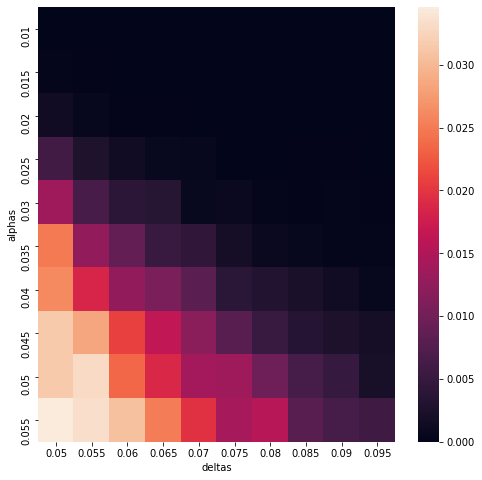

In [90]:
import seaborn as sns

alphas = [round(i,3) for i in np.arange(0.01,0.06,0.005)]
deltas = [round(i,3) for i in np.arange(0.05,0.1,0.005)]

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(aft, yticklabels=alphas, xticklabels=deltas)
ax.set(xlabel='deltas', ylabel='alphas')


==> By analysing this matrix, and since we prefer small deltas so as to not affect images greatly: We choose the values alpha = 0.01, delta = 0.05

In [100]:
batch_size = 5000

seed = 0 

alpha = 0.01
delta = 0.05


acc_advers_imgs = []
for max_iter in range(0,10):
  
  if max_iter == 0:
    indices_chosen, x_adversarial_train, y_adversarial_train = generate_adversarials_train_PGD(batch_size, delta, alpha, 1, seed)
    acc_orig_imgs = model.evaluate(x=x_train[indices_chosen].reshape(-1,32,32,3), y=y_train[indices_chosen].reshape(-1,10), verbose=0)[1]
    acc_advers_imgs.append(acc_orig_imgs)
    print(f' Accuracy for iter {max_iter}, delta = {delta}, alpha = {alpha}, {round(acc_orig_imgs*100,3)} %')  #fix experiments randomness
    continue

  indices_chosen, x_adversarial_train, y_adversarial_train = generate_adversarials_train_PGD(batch_size, delta, alpha, max_iter, seed)
  acc_advers_imgs.append(model.evaluate(x=np.array(x_adversarial_train).reshape(-1,32,32,3), y=np.array(y_adversarial_train), verbose=0)[1])
  
  print(f' Accuracy for iter {max_iter}, delta = {delta}, alpha = {alpha}, {round(acc_advers_imgs[-1]*100,3)} %')

 Accuracy for iter 0, delta = 0.05, alpha = 0.01, 95.12 %
 Accuracy for iter 1, delta = 0.05, alpha = 0.01, 34.84 %
 Accuracy for iter 2, delta = 0.05, alpha = 0.01, 4.14 %
 Accuracy for iter 3, delta = 0.05, alpha = 0.01, 0.34 %
 Accuracy for iter 4, delta = 0.05, alpha = 0.01, 0.04 %
 Accuracy for iter 5, delta = 0.05, alpha = 0.01, 0.0 %
 Accuracy for iter 6, delta = 0.05, alpha = 0.01, 0.0 %
 Accuracy for iter 7, delta = 0.05, alpha = 0.01, 0.0 %
 Accuracy for iter 8, delta = 0.05, alpha = 0.01, 0.0 %
 Accuracy for iter 9, delta = 0.05, alpha = 0.01, 0.0 %


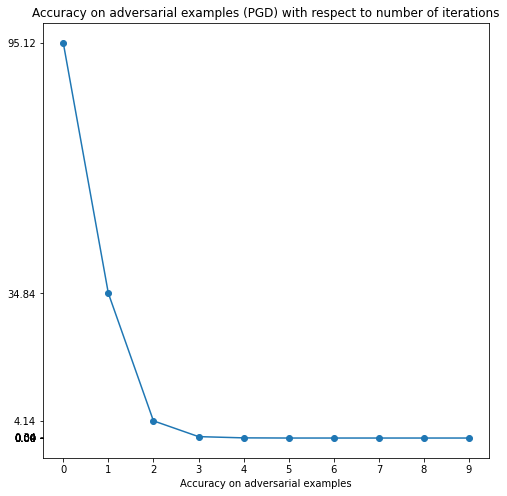

In [109]:
plt.figure(figsize=(8,8))
plt.plot(list(range(0,10)), 100*np.array(acc_advers_imgs), '-o')
plt.xticks(list(range(0,10)))
plt.yticks(list(100*np.array(acc_advers_imgs)))
plt.xlabel('Nb_iterations')
plt.xlabel('Accuracy on adversarial examples')
plt.title('Accuracy on adversarial examples (PGD) with respect to number of iterations')
plt.show()

# Run PGD on test set

In [110]:
batch_size = 5000
delta = 0.05
alpha = 0.01
max_iter = 5

#fix experiments randomness
seed = 0 

indices_chosen, x_adversarial_test, y_adversarial_test = generate_adversarials_test_PGD(batch_size, delta, alpha, max_iter, seed)

In [111]:
print(f'Accuracy on batch of test images =  {model.evaluate(x=x_test[indices_chosen].reshape(-1,32,32,3), y=y_test[indices_chosen].reshape(-1,10), verbose=0)[1]*100} %')

print(f'Accuracy on the same batch of test adversarial images for delta = {delta}, alpha = {alpha}, {model.evaluate(x=np.array(x_adversarial_test).reshape(-1,32,32,3), y=np.array(y_adversarial_test), verbose=0)[1]*100} %')

Accuracy on batch of test images =  85.33999919891357 %
Accuracy on the same batch of test adversarial images for delta = 0.05, alpha = 0.01, 0.03999999898951501 %


Before attack :
After attack :


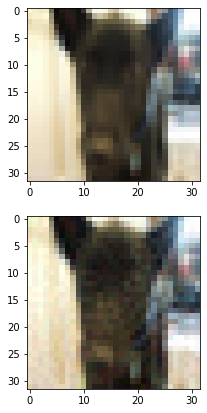

In [112]:
ind = random.randint(0,batch_size-1)
plt.figure(figsize=(7,7))
print("Before attack :")
plt.subplot(2,1,1)
plt.imshow(x_test[indices_chosen[ind]].reshape(32,32,3))
print("After attack :")
plt.subplot(2,1,2)
plt.imshow(x_adversarial_test[ind].reshape(32,32,3))

# **PGD adversarial training :**